In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F


device = 'cpu'
if torch.cuda.is_available():
	device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
	device = 'mps'
print(f"Using device {device}")

Using device cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# data_file = '/content/drive/MyDrive/dataset/NimrodMLdata-1000x40x40x20-seed1.dat'


data_file = './dataset/NimrodMLdata-1000x40x40x20-seed1.dat'

Mounted at /content/drive


In [ ]:
class WeatherDataset(Dataset):
	def __init__(self):
		W, H, C, B = 40, 40, 20, 1000
		data = np.loadtxt(data_file, comments='#', dtype=int)

		# index, H, W, t
		x = torch.from_numpy(data.ravel().reshape(B, C, H, W).transpose(0, 2, 3, 1))

		# Normalization
		x = x.float()
		min_val = x.amin(dim=(1, 2), keepdim=True)
		max_val = x.amax(dim=(1, 2), keepdim=True)
		x = (x - min_val) / (max_val - min_val + 1e-8)

		self.x = x.to(device)
		self.n_samples = B * 17

	def __getitem__(self, index):
		sequence_index = index // 17
		x =  torch.stack([self.x[sequence_index, :, :, index % 17],
										self.x[sequence_index, :, :, index % 17 + 1],
										self.x[sequence_index, :, :, index % 17 + 2]]
										)

		y = self.x[sequence_index, :, :, index % 17 + 3]

		return x, y

	def __len__(self):
		return self.n_samples

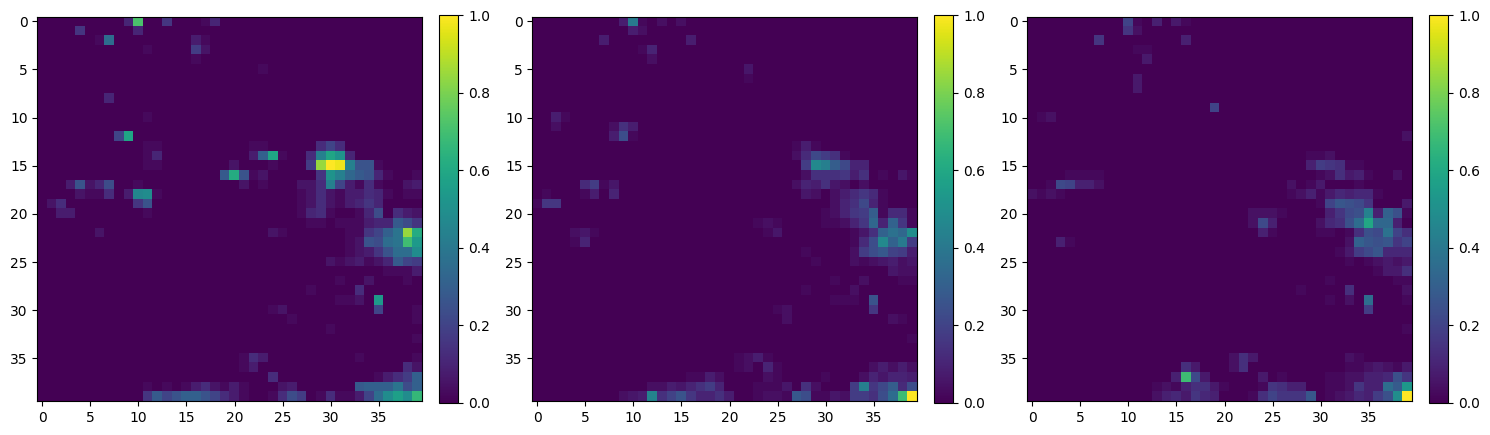

In [ ]:
dataset = WeatherDataset()
x, y = dataset[100]

num_images = len(x)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, image in enumerate(x):
	img = axes[i].imshow(image.to('cpu'), cmap='viridis')
	fig.colorbar(img, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
class ConvBlock(nn.Sequential):
	def __init__(self, in_channels, out_channels):
		# The result is actually 5 x 5 convolution, but more efficient than using a 5 x 5 filter
		super().__init__(
			nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.GELU(approximate='tanh'),
			nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.GELU(approximate='tanh')
		)



class EncoderBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.conv = ConvBlock(in_channels, out_channels)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

	def forward(self, x):
		# We return the features BEFORE pooling to use as a skip connection
		x = self.conv(x)
		p = self.pool(x)
		return x, p



class DecoderBlock(nn.Module):
	def __init__(self, in_channels, skip_channels, out_channels):
		super().__init__()
		self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
		self.conv = ConvBlock(out_channels + skip_channels, out_channels)

	def forward(self, x, skip):
		x = self.upsample(x)
		x = torch.cat([x, skip], dim=1)
		return self.conv(x)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, input_channels, output_channels, num_images=3, dim_feedforward=512, nhead=8, num_layers=2):
        super().__init__()

        self.embed_dim = input_channels * num_images

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.proj_out = nn.Linear(self.embed_dim, output_channels)
        self.pos_embedding = nn.Parameter(torch.randn(1, 2048, self.embed_dim))

    def forward(self, x, y, z):
        combined = torch.cat([x, y, z], dim=1)
        B, C, H, W = combined.shape
        seq_len = H * W
        flat = combined.flatten(2).permute(0, 2, 1)
        flat = flat + self.pos_embedding[:, :seq_len, :]
        out = self.transformer_encoder(flat)
        out = self.proj_out(out)
        out = out.permute(0, 2, 1).view(B, -1, H, W)

        return out

In [ ]:
class TransformersUNet(nn.Module):
	def __init__(self):
		super().__init__()
		# Encoder
		self.enc1 = EncoderBlock(1, 16)
		self.enc2 = EncoderBlock(16, 32)

		# Transformer
		self.transformer = TransformerBlock(
            input_channels=32,
            output_channels=64,
            num_images=3,
            num_layers=1
        )

		# Decoder
		self.dec2 = DecoderBlock(64, 32, 32)
		self.dec1 = DecoderBlock(32, 16, 16)

		self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x, y, z):
		x1, p1 = self.enc1(x)
		x2, p1 = self.enc2(p1)

		y1, p2 = self.enc1(y)
		y2, p2 = self.enc2(p2)

		z1, p3 = self.enc1(z)
		z2, p3 = self.enc2(p3)

		# Transformer
		a = self.transformer(p1, p2, p3)

		# Decoder + Skip Connections
		d2 = self.dec2(a, z2 + y2 + x2)
		d1 = self.dec1(d2, z1 + y1 + x1)

		f = self.final_conv(d1)
		return self.sigmoid(f)


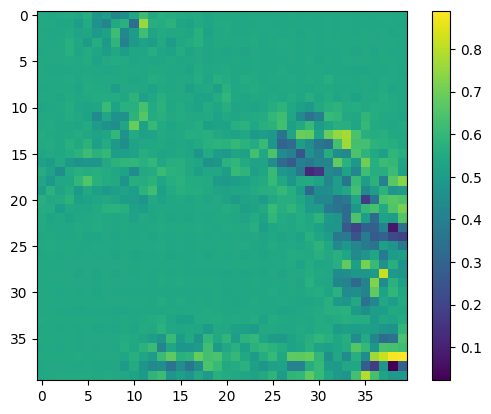

In [ ]:
model = TransformersUNet()
model.to(device)

y = model.forward(x[0].unsqueeze(0).unsqueeze(0), x[1].unsqueeze(0).unsqueeze(0), x[2].unsqueeze(0).unsqueeze(0))


plt.imshow(y.detach().cpu().squeeze().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
class SharpWeatherLoss(nn.Module):
    def __init__(self, weight_intensity=20.0, weight_edge=1.0):
        super(SharpWeatherLoss, self).__init__()
        self.w_int = weight_intensity
        self.w_edge = weight_edge
        self.l1 = nn.L1Loss(reduction='none')

    def gradient_loss(self, pred, target):
        pred_dy = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
        pred_dx = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])

        target_dy = torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :])
        target_dx = torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1])

        loss = F.l1_loss(pred_dy, target_dy) + F.l1_loss(pred_dx, target_dx)
        return loss

    def forward(self, pred, target):
        l1_error = self.l1(pred, target)
        pixel_weights = 1.0 + (self.w_int * target)
        loss_intensity = (l1_error * pixel_weights).mean()

        loss_edge = self.gradient_loss(pred, target)

        return loss_intensity + (self.w_edge * loss_edge)

# Trainig Setup
n_epochs = 30
criterion = SharpWeatherLoss(weight_intensity=20.0, weight_edge=2.0)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters())

total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len   = int(0.15 * total_len)
test_len  =  int(0.15 * total_len)

train_data, val_data, test_data = random_split(
    dataset,
    [train_len, val_len, test_len]
)

train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=100, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=False)

In [ ]:
# Trainig Loop
for epoch in range(n_epochs):
  model.train()
  running_loss = 0.0

  for X, Y in train_loader:
    X, Y = X.to(device), Y.to(device)

    x_in = X[:, 0:1, :, :]
    y_in = X[:, 1:2, :, :]
    z_in = X[:, 2:3, :, :]
    Y = Y.unsqueeze(1)

    optimizer.zero_grad()
    Y_hat = model(x_in, y_in, z_in)
    loss = criterion(Y_hat, Y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for X, Y in val_loader:
      X, Y = X.to(device), Y.to(device)

      x_in = X[:, 0:1, :, :]
      y_in = X[:, 1:2, :, :]
      z_in = X[:, 2:3, :, :]
      Y = Y.unsqueeze(1)

      Y_hat = model(x_in, y_in, z_in)
      loss = criterion(Y_hat, Y)
      val_loss += loss.item()

  avg_train_loss = running_loss / len(train_loader)
  avg_val_loss = val_loss / len(val_loader)

  print(f"Epoch [{epoch+1}/{n_epochs}] "f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


print("Training Complete")

Epoch [1/30] Train Loss: 0.6515 | Val Loss: 0.4991
Epoch [2/30] Train Loss: 0.4054 | Val Loss: 0.3411
Epoch [3/30] Train Loss: 0.3121 | Val Loss: 0.2921
Epoch [4/30] Train Loss: 0.2832 | Val Loss: 0.2749
Epoch [5/30] Train Loss: 0.2705 | Val Loss: 0.2666
Epoch [6/30] Train Loss: 0.2635 | Val Loss: 0.2611
Epoch [7/30] Train Loss: 0.2592 | Val Loss: 0.2566
Epoch [8/30] Train Loss: 0.2559 | Val Loss: 0.2550
Epoch [9/30] Train Loss: 0.2532 | Val Loss: 0.2580
Epoch [10/30] Train Loss: 0.2510 | Val Loss: 0.2517
Epoch [11/30] Train Loss: 0.2494 | Val Loss: 0.2509
Epoch [12/30] Train Loss: 0.2478 | Val Loss: 0.2503
Epoch [13/30] Train Loss: 0.2467 | Val Loss: 0.2499
Epoch [14/30] Train Loss: 0.2452 | Val Loss: 0.2485
Epoch [15/30] Train Loss: 0.2444 | Val Loss: 0.2491
Epoch [16/30] Train Loss: 0.2434 | Val Loss: 0.2504
Epoch [17/30] Train Loss: 0.2422 | Val Loss: 0.2479
Epoch [18/30] Train Loss: 0.2411 | Val Loss: 0.2474
Epoch [19/30] Train Loss: 0.2409 | Val Loss: 0.2476
Epoch [20/30] Train L

In [ ]:
data_iter = iter(val_loader)

model.eval()
test_loss = 0.0

with torch.no_grad():
  for X, Y in test_loader:
    X, Y = X.to(device), Y.to(device)

    x_in = X[:, 0:1, :, :]
    y_in = X[:, 1:2, :, :]
    z_in = X[:, 2:3, :, :]
    Y = Y.unsqueeze(1)

    Y_hat = model(x_in, y_in, z_in)
    loss = criterion(Y_hat, Y)
    test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.2507


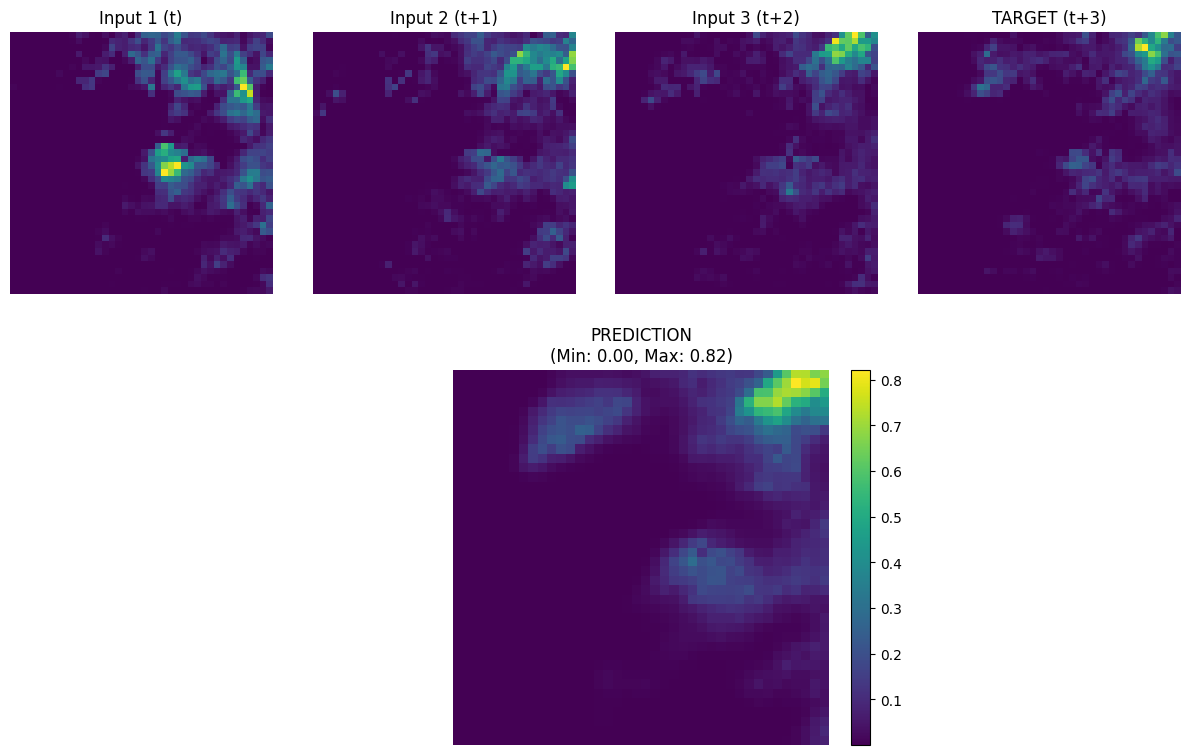

In [ ]:
# 1. Get a fresh batch
# Using the iterator method so you can re-run this cell to see different samples
if 'data_iter' not in locals():
    data_iter = iter(test_loader)

try:
    X, Y = next(data_iter)
except StopIteration:
    data_iter = iter(val_loader)
    X, Y = next(data_iter)

X, Y = X.to(device), Y.to(device)

# 2. Make Prediction
model.eval()
with torch.no_grad():
    x_in = X[:, 0:1, :, :]
    y_in = X[:, 1:2, :, :]
    z_in = X[:, 2:3, :, :]

    pred = model(x_in, y_in, z_in)

input_1 = X[0, 0].cpu().numpy()
input_2 = X[0, 1].cpu().numpy()
input_3 = X[0, 2].cpu().numpy()
target  = Y[0].cpu().numpy()
prediction = pred[0, 0].cpu().numpy()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(input_1, cmap='viridis')
ax1.set_title("Input 1 (t)")
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(input_2, cmap='viridis')
ax2.set_title("Input 2 (t+1)")
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(input_3, cmap='viridis')
ax3.set_title("Input 3 (t+2)")
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
im4 = ax4.imshow(target, cmap='viridis')
ax4.set_title("TARGET (t+3)")
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 1:3])
im5 = ax5.imshow(prediction, cmap='viridis')
ax5.set_title(f"PREDICTION\n(Min: {prediction.min():.2f}, Max: {prediction.max():.2f})")
ax5.axis('off')
plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

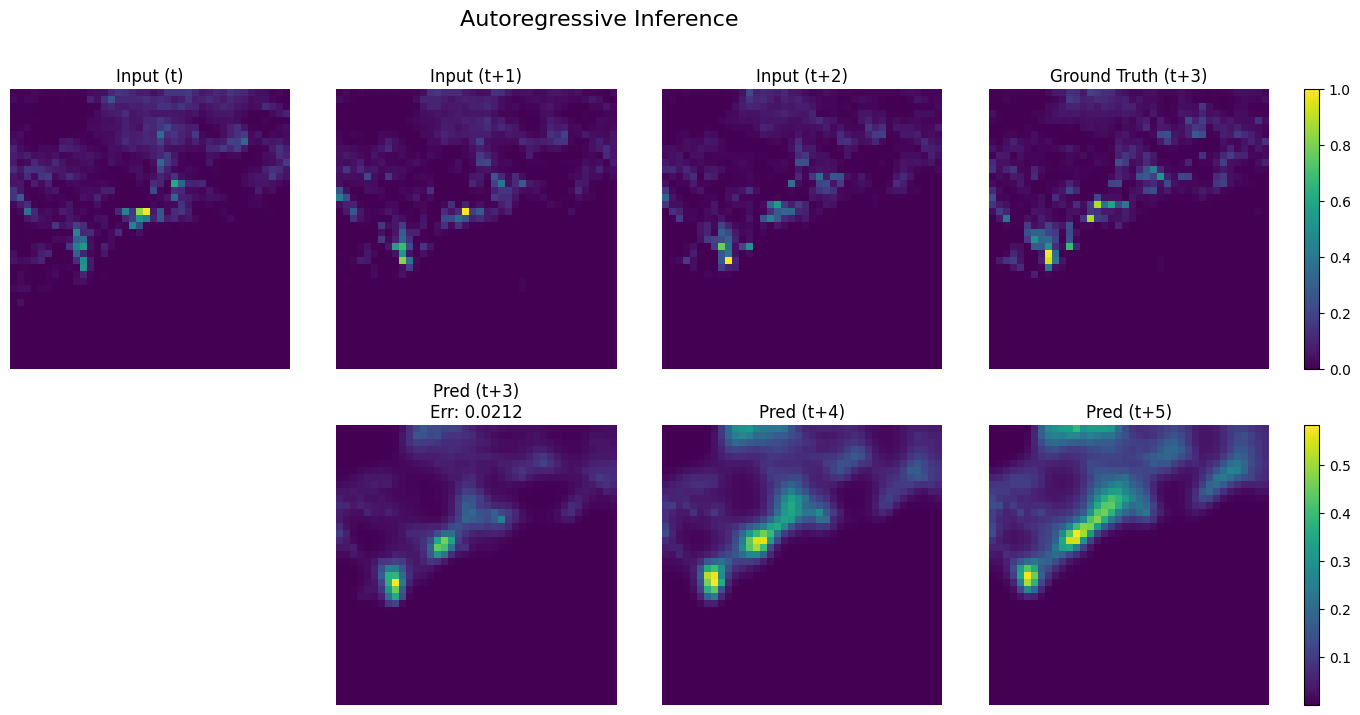

In [ ]:
# 1. Get a fresh batch
if 'data_iter' not in locals():
    data_iter = iter(test_loader)

try:
    X, Y = next(data_iter)
except StopIteration:
    data_iter = iter(val_loader)
    X, Y = next(data_iter)

X, Y = X.to(device), Y.to(device)

# 2. Autoregressive Prediction Loop
model.eval()
predictions = []

with torch.no_grad():
    input_buffer = [X[:, 0:1, :, :], X[:, 1:2, :, :], X[:, 2:3, :, :]]

    for i in range(3):
        x_in = input_buffer[-3]
        y_in = input_buffer[-2]
        z_in = input_buffer[-1]

        pred = model(x_in, y_in, z_in)
        predictions.append(pred)
        input_buffer.append(pred)

# 3. Visualization
in1_np = X[0, 0].cpu().numpy()
in2_np = X[0, 1].cpu().numpy()
in3_np = X[0, 2].cpu().numpy()
target_np = Y[0].cpu().numpy()

pred1_np = predictions[0][0, 0].cpu().numpy()
pred2_np = predictions[1][0, 0].cpu().numpy()
pred3_np = predictions[2][0, 0].cpu().numpy()

fig = plt.figure(figsize=(16, 8))

# FIX: Add a 5th column (index 4) specifically for colorbars
# width_ratios: First 4 columns are weight 1, last column is weight 0.05 (thin)
gs = fig.add_gridspec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.1)

# --- Row 1: The Context ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(in1_np, cmap='viridis')
ax1.set_title("Input (t)")
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(in2_np, cmap='viridis')
ax2.set_title("Input (t+1)")
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(in3_np, cmap='viridis')
ax3.set_title("Input (t+2)")
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
im4 = ax4.imshow(target_np, cmap='viridis')
ax4.set_title("Ground Truth (t+3)")
ax4.axis('off')

# Colorbar for Row 1: Put it in the 5th column (gs[0, 4])
cax1 = fig.add_subplot(gs[0, 4])
plt.colorbar(im4, cax=cax1)

# --- Row 2: The Future ---
ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(pred1_np, cmap='viridis')
ax5.set_title(f"Pred (t+3)\nErr: {abs(pred1_np - target_np).mean():.4f}")
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 2])
im6 = ax6.imshow(pred2_np, cmap='viridis')
ax6.set_title("Pred (t+4)")
ax6.axis('off')

ax7 = fig.add_subplot(gs[1, 3])
im7 = ax7.imshow(pred3_np, cmap='viridis')
ax7.set_title("Pred (t+5)")
ax7.axis('off')

# Colorbar for Row 2: Put it in the 5th column (gs[1, 4])
cax2 = fig.add_subplot(gs[1, 4])
plt.colorbar(im7, cax=cax2)

plt.suptitle("Autoregressive Inference", fontsize=16)
# Use subplots_adjust if things are too tight, though wspace handles most of it
plt.subplots_adjust(right=0.95)
plt.show()